- GAN
  - 생성자, 판별자의 싸움
  - 생성자 : 랜덤한 잡음을 원래 데이터에서 샘플링한 것처럼 보이는 샘플을 만든다

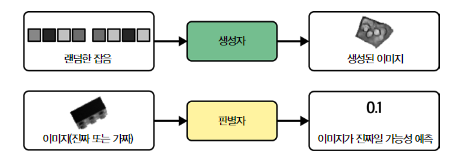

In [1]:
# 데이터 링크공유
# https://drive.google.com/drive/folders/12lUhSGWBwYrxWFGW_Ql5rTk5uDtWfao4?usp=sharing
# 원본 https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images

In [ ]:
# 각자 자신의 환경에 맞게 수정
!unzip '/content/drive/MyDrive/lego_block_data/archive.zip' -d lego

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
from utils import display, sample_batch

In [ ]:
# utils.py가 필요 (display할때)

In [5]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 100 # 훈련이 오래 걸려 에포크 횟수를 300에서 100으로 줄입니다.
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [ ]:
# 텐서플로 데이터 셋 만들기
from glob import glob
temp =  glob('/content/lego/dataset/*');
[paths for paths in temp if paths.split('.')[-1] !='png']

In [ ]:
from PIL import Image
Image.open(temp[-1])

In [18]:
train_data = utils.image_dataset_from_directory(
    '/content/lego/dataset/',
    labels = None,
    image_size=(64,64),
    batch_size=128,
    shuffle = True,
    seed=42,
    color_mode='grayscale'
)

Found 40000 files belonging to 1 classes.


In [22]:
# 데이터 전처리
# 원본데이터 : 0 ~ 255
# GAN을 훈련할때는 데이터 -1 ~ 1 범위로 스케일 --> 마지막층 시그모이드
# 대신에 더 강한 그레이디언트 tanh를 사용하기 위해서
def preprocess(img):
  img = (tf.cast(img,'float32')-127.5 / 127.5)
  return img

train = train_data.map(lambda x : preprocess(x))

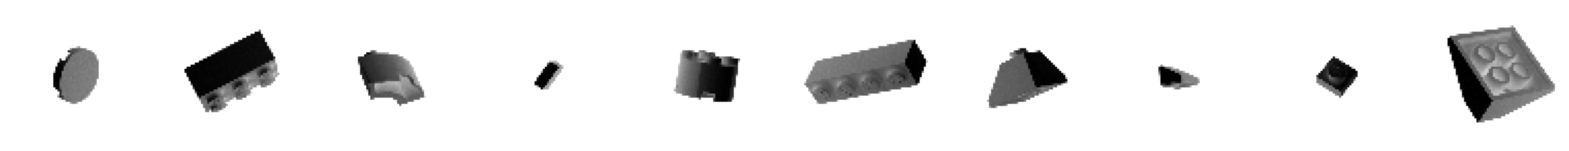

In [23]:
# 이지미 시각화
train_sample = sample_batch(train)
display(train_sample)

In [24]:
# 판별자  생성
# inputlayer - conv2d - leakyrelu -dropuout

# conv2d - batchnormal- leakyrelu -dropuout
# conv2d - batchnormal- leakyrelu -dropuout
# conv2d - batchnormal- leakyrelu -dropuout

# conv2d - flattern

In [28]:
discriminator_input = layers.Input(shape=(64,64,1))
# 바이어스 false로 하면 학습파라메터가 감소, 계산효율성증가, 특정 데이터나 문제에 따라서 성능이 향상
x = layers.Conv2D(64,kernel_size=4,strides=2,padding='same',use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False, activation='sigmoid')(x)
discriminator_output = layers.Flatten()(x)
discriminator = models.Model(discriminator_input,discriminator_output)  # Dense층을 사용하지 않는 이유는 (None, 1, 1, 1)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                             

In [ ]:
# 생성자의 입력은 VAE와 동일한 목적으로
# 생성자
generator_input = layers.Input(shape=(100,))  # input층은 길이가 100인 벡터